In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.9.1


In [3]:
keras = tf.keras
layers = tf.keras.layers

In [4]:
train_image_path = glob.glob('dog/train/*/*.jpg')

In [5]:
len(train_image_path)

367

In [6]:
train_image_path[290:300]

['dog/train\\healthy\\ia_100011574.jpg',
 'dog/train\\healthy\\ia_100011581.jpg',
 'dog/train\\healthy\\ia_100011582.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_107.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_108.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_125.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_19.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_26.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_30.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_31.jpg']

In [7]:
train_image_path[-5:]

['dog/train\\unhealthy\\ia_100009834.jpg',
 'dog/train\\unhealthy\\ia_100010146.jpg',
 'dog/train\\unhealthy\\ia_100011148.jpg',
 'dog/train\\unhealthy\\ia_100011313.jpg',
 'dog/train\\unhealthy\\ia_100011584.jpg']

In [8]:
train_image_label = [int(path.split('\\')[1] == 'healthy') for path in train_image_path]

In [9]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [10]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [11]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255
    #label = tf.reshape(label, [1])
    return image, label

In [12]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [15]:
train_image_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

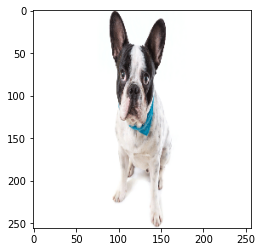

In [16]:
for img, label in train_image_ds.take(2):
    plt.imshow(img)

In [17]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [18]:
train_image_ds = train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)

In [19]:
test_image_path = glob.glob('dog/test/*/*.jpg')
test_image_label = [int(path.split('\\')[1] == 'healthy') for path in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)

In [20]:
test_count = len(test_image_path)
test_count

95

In [21]:
covn_base = keras.applications.xception.Xception(weights='imagenet', 
                                                 include_top=False,
                                                 input_shape=(256, 256, 3),
                                                 pooling='avg')                                   

83683744/83683744 [==============================] - 3s 0us/step


In [22]:
covn_base.trainable = False

In [23]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [24]:
model = keras.Sequential()
model.add(covn_base)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [26]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['acc'])

C:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
initial_epochs = 15

In [28]:
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 1/15
11/11 [==============================] - 31s 2s/step - loss: 0.6060 - acc: 0.8040 - val_loss: 0.1431 - val_acc: 1.0000
Epoch 2/15
11/11 [==============================] - 23s 2s/step - loss: 0.5083 - acc: 0.7983 - val_loss: 0.1828 - val_acc: 1.0000
Epoch 3/15
11/11 [==============================] - 23s 2s/step - loss: 0.4640 - acc: 0.8068 - val_loss: 0.3406 - val_acc: 0.9844
Epoch 4/15
11/11 [==============================] - 23s 2s/step - loss: 0.4271 - acc: 0.8324 - val_loss: 0.1355 - val_acc: 1.0000
Epoch 5/15
11/11 [==============================] - 23s 2s/step - loss: 0.4015 - acc: 0.8267 - val_loss: 0.2714 - val_acc: 0.9844
Epoch 6/15
11/11 [==============================] - 23s 2s/step - loss: 0.3736 - acc: 0.8381 - val_loss: 0.2297 - val_acc: 0.9844
Epoch 7/15
11/11 [==============================] - 25s 2s/step - loss: 0.3708 - acc: 0.8636 - val_loss: 0.0984 - val_acc: 1.0000
Epoch 8/15
11/11 [==============================] - 22s 2s/step - loss: 0.4091 - acc: 0.82

In [29]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

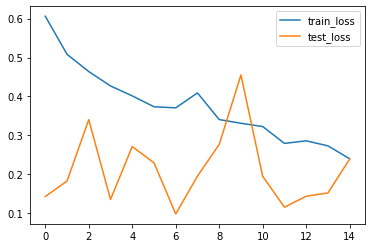

In [30]:
plt.plot(history.epoch, history.history.get('loss'), label='train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='test_loss')
plt.legend()

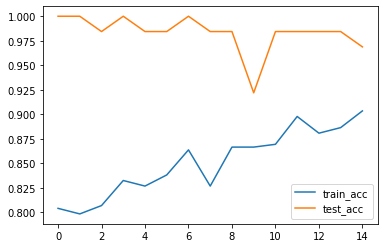

In [31]:
plt.plot(history.epoch, history.history.get('acc'), label='train_acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='test_acc')
plt.legend()

In [32]:
covn_base.trainable = True

In [33]:
len(covn_base.layers)

133

In [34]:
fine_tune_at = -33

In [35]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,911,081
Trainable params: 10,527,945
Non-trainable params: 11,383,136
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['accuracy'])

In [38]:
initial_epochs = 15
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch = initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 16/25
11/11 [==============================] - 48s 4s/step - loss: 0.4139 - accuracy: 0.8324 - val_loss: 0.1473 - val_accuracy: 0.9844
Epoch 17/25
11/11 [==============================] - 43s 4s/step - loss: 0.2412 - accuracy: 0.9006 - val_loss: 0.0850 - val_accuracy: 0.9844
Epoch 18/25
11/11 [==============================] - 38s 3s/step - loss: 0.1504 - accuracy: 0.9517 - val_loss: 0.0615 - val_accuracy: 0.9844
Epoch 19/25
11/11 [==============================] - 40s 4s/step - loss: 0.1228 - accuracy: 0.9574 - val_loss: 0.0518 - val_accuracy: 0.9844
Epoch 20/25
11/11 [==============================] - 39s 4s/step - loss: 0.0890 - accuracy: 0.9688 - val_loss: 0.0455 - val_accuracy: 0.9844
Epoch 21/25
11/11 [==============================] - 38s 3s/step - loss: 0.0794 - accuracy: 0.9631 - val_loss: 0.0436 - val_accuracy: 0.9844
Epoch 22/25
11/11 [==============================] - 40s 4s/step - loss: 0.0608 - accuracy: 0.9744 - val_loss: 0.0444 - val_accuracy: 0.9688
Epoch 23/25
1

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

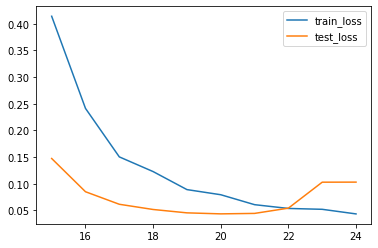

In [40]:
plt.plot(history.epoch, history.history.get('loss'), label='train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='test_loss')
plt.legend()

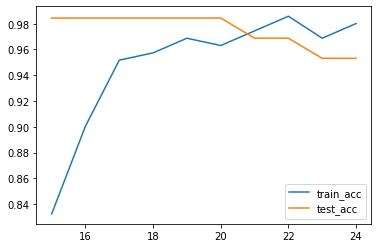

In [41]:
plt.plot(history.epoch, history.history.get('accuracy'), label='train_acc')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='test_acc')
plt.legend()